<a href="https://colab.research.google.com/github/EmKelsall/ADS2002---Catheter-Placement-Project/blob/main/ResNet%20-%20NGT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ResNet - NGT

In [ ]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from PIL import Image
import ast
import os
import cv2
from tqdm import tqdm

In [ ]:
train_data = pd.read_csv("/kaggle/input/ranzcr-clip-catheter-line-classification/train.csv")
train_data

,StudyInstanceUID,ETT - Abnormal,ETT - Borderline,ETT - Normal,NGT - Abnormal,NGT - Borderline,NGT - Incompletely Imaged,NGT - Normal,CVC - Abnormal,CVC - Borderline,CVC - Normal,Swan Ganz Catheter Present,PatientID
0,1.2.826.0.1.3680043.8.498.26697628953273228189...,0,0,0,0,0,0,1,0,0,0,0,ec89415d1
1,1.2.826.0.1.3680043.8.498.46302891597398758759...,0,0,1,0,0,1,0,0,0,1,0,bf4c6da3c
2,1.2.826.0.1.3680043.8.498.23819260719748494858...,0,0,0,0,0,0,0,0,1,0,0,3fc1c97e5
3,1.2.826.0.1.3680043.8.498.68286643202323212801...,0,0,0,0,0,0,0,1,0,0,0,c31019814
4,1.2.826.0.1.3680043.8.498.10050203009225938259...,0,0,0,0,0,0,0,0,0,1,0,207685cd1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
30078,1.2.826.0.1.3680043.8.498.74257566841157531124...,0,0,1,0,0,0,0,0,1,1,0,5b5b9ac30
30079,1.2.826.0.1.3680043.8.498.46510939987173529969...,0,0,0,0,0,0,0,0,0,1,0,7192404d8
30080,1.2.826.0.1.3680043.8.498.43173270582850645437...,0,0,1,0,0,1,0,1,0,1,0,d4d1b066d
30081,1.2.826.0.1.3680043.8.498.95092491950130838685...,0,0,0,0,0,0,0,0,1,0,0,01a6602b8


In [ ]:
# CVC_train = train_data[["StudyInstanceUID","CVC - Abnormal", "CVC - Borderline", "CVC - Normal"]]
# CVC_train.set_index('StudyInstanceUID', inplace=True)
# CVC_train.head()


train_data = train_data[(train_data['NGT - Incompletely Imaged'] != 1) & (train_data['NGT - Borderline'] != 1 )]

train_data[['NGT - Normal', 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Incompletely Imaged']].value_counts()
train_data['NGT - Present'] = np.where((train_data['NGT - Normal'] == 0) & (train_data['NGT - Abnormal'] == 0) & (train_data['NGT - Borderline'] == 0), 0, 1)

train_data[['NGT - Normal', 'NGT - Abnormal']].value_counts()
# train_data['CVC - Borderline'].value_counts()
# # train_data
# # train_data['CVC - Borderline'] = np.where((train_data['CVC - Normal'] == 1) | (train_data['CVC - Abnormal'] == 1), 0, 0)

# train_data['CVC - Present'] = np.where((train_data['CVC - Abnormal'] == 0) & (train_data['CVC - Normal'] == 0), 0, 1)

# train_data['CVC - Present'].value_counts

# train_data = train_data = train_data[~((train_data[f'{catheter} - Normal'] == 1) & (train_data[f'{catheter} - Abnormal'] == 1))]
# train_data[f'{catheter} - Normal/Abnormal'] = np.where(train_data[f'{catheter} - Normal'] == 1, 1, 0)
# sampled_data = pd.concat([train_data[train_data[f'{catheter} - Normal'] == 1].sample(n=size), train_data[train_data[f'{catheter} - Abnormal'] == 1].sample(n=size)])

/tmp/ipykernel_32/7930340.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['NGT - Present'] = np.where((train_data['NGT - Normal'] == 0) & (train_data['NGT - Abnormal'] == 0) & (train_data['NGT - Borderline'] == 0), 0, 1)


NGT - Normal  NGT - Abnormal
0             0                 21775
1             0                  4768
0             1                   259
1             1                     9
Name: count, dtype: int64

In [ ]:
normalAb = pd.concat([train_data[train_data['NGT - Normal'] == 1].sample(n=125), train_data[train_data['NGT - Abnormal'] == 1].sample(n=125)])
sampled_data = pd.concat([normalAb, train_data[train_data['NGT - Present'] == 0].sample(n=250)])

# sampled_data = pd.concat([train_data[train_data['CVC - Present'] == 1].sample(n=750), train_data[train_data['CVC - Present'] == 0].sample(n=750)])
sampled_data[['NGT - Abnormal', 'NGT - Normal']].value_counts()

NGT - Abnormal  NGT - Normal
0               0               250
                1               125
1               0               122
                1                 3
Name: count, dtype: int64

In [ ]:
def getFileNames(df):
    studyInstance = df['StudyInstanceUID'].tolist()
    studyInstance

    for i in range(len(studyInstance)):
        studyInstance[i] = f'{studyInstance[i]}.jpg'

    return studyInstance


In [ ]:
studyInstance = getFileNames(sampled_data)

In [ ]:
def processImages(filenames,train_test):

    imgs = []
    FileIDs = []
    lst = []


    desired_channels = 3

    count = 0
    for file in tqdm(filenames, position=0, leave=True):
        # Making sure the images are the same pixel size
        img = Image.open(f"/kaggle/input/ranzcr-clip-catheter-line-classification/{train_test}/{file}")
        img = img.resize((300, 300))
        img = np.array(img)

        # Ensure that the image has 3 channels (RGB)
        if img.shape[-1] != 3:
            img = np.stack((img,) * 3, axis=-1)  # Convert grayscale to RGB by duplicating channels

        imgs.append(img)  # Append the 4D image to the list

        # Save filename for later
        FileIDs.append(file)

        count += 1

    # Convert the list of images to a numpy array
    imgs = np.array(imgs)
    return imgs, FileIDs

In [ ]:
train_imgs, fileIDs = processImages(studyInstance, 'train')

100%|██████████| 500/500 [00:28<00:00, 17.68it/s]


In [ ]:
#cleaning up the labels
UID = []
for i in range(len(fileIDs)):
  UID.append(fileIDs[i].replace(".jpg",""))

UID[0:10]

['1.2.826.0.1.3680043.8.498.65108787638800618504526868718911956744',
 '1.2.826.0.1.3680043.8.498.10994531668075363818266044591102527717',
 '1.2.826.0.1.3680043.8.498.49807016252879260088849140880053788065',
 '1.2.826.0.1.3680043.8.498.75445875862496758679136471899539633375',
 '1.2.826.0.1.3680043.8.498.89369371707034087254309411362762932453',
 '1.2.826.0.1.3680043.8.498.44476689473309133836581960962296326162',
 '1.2.826.0.1.3680043.8.498.11671797616816873403428410268840599989',
 '1.2.826.0.1.3680043.8.498.80301292569484402631034426000610039631',
 '1.2.826.0.1.3680043.8.498.10153667166658606707063887247369405550',
 '1.2.826.0.1.3680043.8.498.10018307055250055778245370273733850307']

In [ ]:
columns_to_drop = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Normal',
                  "NGT - Incompletely Imaged", "Swan Ganz Catheter Present", "PatientID", "CVC - Borderline", 'CVC - Abnormal', 'CVC - Normal']

NGTsampled_data = sampled_data.drop(columns=columns_to_drop, axis=1)

NGTsampled_data.set_index('StudyInstanceUID', inplace=True)

In [ ]:
train_labels_df = np.empty((0,3))
data = []

for ID in UID:
    data.append(NGTsampled_data.loc[ID])

train_labels_df = pd.DataFrame(data)



train_labels_df = train_labels_df.reindex(UID)
train_labels = train_labels_df['NGT - Present'].values
# train_labels = train_labels_df.values
train_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.model_selection import train_test_split

# Split your data into training and temporary data (combined validation and test)
train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(train_imgs, train_labels, test_size=0.2, random_state=42)

# Split the temporary data into validation and test sets
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, random_state=42)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

# NORMAL OR ABNORMAL

In [ ]:
def buildTrainData(catheter, train_data, size):

    train_data = train_data[train_data[f'{catheter} - Present'] == 1]
    train_data = train_data = train_data[~((train_data[f'{catheter} - Normal'] == 1) & (train_data[f'{catheter} - Abnormal'] == 1))]
    train_data[f'{catheter} - Normal/Abnormal'] = np.where(train_data[f'{catheter} - Normal'] == 1, 1, 0)
    sampled_data = pd.concat([train_data[train_data[f'{catheter} - Normal'] == 1].sample(n=size), train_data[train_data[f'{catheter} - Abnormal'] == 1].sample(n=size)])

    return sampled_data


In [ ]:
sample = buildTrainData('NGT', train_data, 250)
sample[['NGT - Normal', 'NGT - Abnormal']].value_counts()

NGT - Normal  NGT - Abnormal
0             1                 250
1             0                 250
Name: count, dtype: int64

In [ ]:
nAb_data = getFileNames(sample)

ngt_imgs, fileIDs = processImages(nAb_data, 'train')

100%|██████████| 500/500 [00:27<00:00, 18.45it/s]


In [ ]:
UID = []
for i in range(len(fileIDs)):
  UID.append(fileIDs[i].replace(".jpg",""))


columns_to_drop = ['ETT - Abnormal', 'ETT - Borderline', 'ETT - Normal', 'NGT - Abnormal', 'NGT - Borderline', 'NGT - Normal',
                  "NGT - Incompletely Imaged", "Swan Ganz Catheter Present", "PatientID", "CVC - Borderline", 'CVC - Abnormal', 'CVC - Normal', 'NGT - Present']

NGTsample = sample.drop(columns=columns_to_drop, axis=1)

NGTsample.set_index('StudyInstanceUID', inplace=True)

NGTsample

,NGT - Normal/Abnormal
StudyInstanceUID,
1.2.826.0.1.3680043.8.498.10361726213889360297221617147966588121,1
1.2.826.0.1.3680043.8.498.31878102211936522453660823173608769080,1
1.2.826.0.1.3680043.8.498.45827680246405599842114977421380316000,1
1.2.826.0.1.3680043.8.498.12695704282968142311826592823035716895,1
1.2.826.0.1.3680043.8.498.90515750401474061451165676214491278451,1
...,...
1.2.826.0.1.3680043.8.498.67118987555969342287786734708355895624,0
1.2.826.0.1.3680043.8.498.10006237848798781176388878065969229683,0
1.2.826.0.1.3680043.8.498.53464106532734321247813859991912797211,0


In [ ]:
train_labels_df = np.empty((0,3))
data = []

for ID in UID:
    data.append(NGTsample.loc[ID])

train_labels_df = pd.DataFrame(data)



train_labels_df = train_labels_df.reindex(UID)
ngt_labels = train_labels_df['NGT - Normal/Abnormal'].values
# train_labels = train_labels_df.values
ngt_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
from sklearn.model_selection import train_test_split

# Split your data into training and temporary data (combined validation and test)
trainNGT_imgs, temp_imgs, trainNGT_labels, temp_labels = train_test_split(ngt_imgs, ngt_labels, test_size=0.2, random_state=42)

# Split the temporary data into validation and test sets
valNGT_imgs, testNGT_imgs, valNGT_labels, testNGT_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, random_state=42)

In [ ]:
len(train_labels)

400

In [ ]:
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model


from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the ResNet50 model with pre-trained weights
base_model = ResNet50(weights='imagenet', include_top=False)

# Add dropout and batch normalization to custom fully connected layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# First Output Branch: CVC Catheter Presence (Binary Classification)
output_CVCpresent = Dense(1, activation='sigmoid', name='output_NGTpresent')(x)

# Add a separate set of layers for the new task
y = base_model.output
y = GlobalAveragePooling2D()(y)
y = Dense(1024, activation='relu')(y)
y = BatchNormalization()(y)
y = Dropout(0.5)(y)

# Second Output Branch: CVC Placement (Binary Classification)
output_cvc_placement = Dense(1, activation='sigmoid', name='output_NGTnormalAbnormal')(y)

# Combine the two output branches
combined_model = Model(inputs=base_model.input, outputs=[output_CVCpresent, output_cvc_placement])

# Compile the combined model with optimizer and loss functions for both tasks
combined_model.compile(optimizer='SGD',
                       loss={'output_NGTpresent': 'binary_crossentropy', 'output_NGTnormalAbnormal': 'binary_crossentropy'},
                       metrics={'output_NGTpresent': 'accuracy', 'output_NGTnormalAbnormal': 'accuracy'})

# # Reduce learning rate when the validation loss plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Save the best model during training
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

history = combined_model.fit(
    {'input_1': train_imgs},
    {'output_NGTpresent': train_labels, 'output_NGTnormalAbnormal': trainNGT_labels},
    epochs=30,
    validation_data=(
        {'input_1': val_imgs},
        {'output_NGTpresent': val_labels, 'output_NGTnormalAbnormal': valNGT_labels}
    ),
    callbacks=[reduce_lr, early_stop, model_checkpoint]
)

# # Evaluate the combined model
# test_loss, [test_accuracy_catheter, test_accuracy_cvc_placement] = combined_model.evaluate(
#     {'input_1': test_imgs},
#     {'output_catheter': test_labels, 'output_cvc_placement': testCVC_labels}
# )

# print(f'Test Accuracy (Catheter): {test_accuracy_catheter * 100:.2f}%')
# print(f'Test Accuracy (CVC Placement): {test_accuracy_cvc_placement * 100:.2f}%')

94765736/94765736 [==============================] - 1s 0us/step
Epoch 1/30
13/13 [==============================] - 37s 769ms/step - loss: 1.5461 - output_NGTpresent_loss: 0.7812 - output_NGTnormalAbnormal_loss: 0.7649 - output_NGTpresent_accuracy: 0.6650 - output_NGTnormalAbnormal_accuracy: 0.6425 - val_loss: 1.4715 - val_output_NGTpresent_loss: 0.7254 - val_output_NGTnormalAbnormal_loss: 0.7460 - val_output_NGTpresent_accuracy: 0.4800 - val_output_NGTnormalAbnormal_accuracy: 0.5000 - lr: 0.0100
Epoch 2/30
13/13 [==============================] - 5s 393ms/step - loss: 0.8097 - output_NGTpresent_loss: 0.4042 - output_NGTnormalAbnormal_loss: 0.4055 - output_NGTpresent_accuracy: 0.8275 - output_NGTnormalAbnormal_accuracy: 0.8225 - val_loss: 1.3660 - val_output_NGTpresent_loss: 0.6730 - val_output_NGTnormalAbnormal_loss: 0.6930 - val_output_NGTpresent_accuracy: 0.6200 - val_output_NGTnormalAbnormal_accuracy: 0.6000 - lr: 0.0100
Epoch 3/30
13/13 [==============================] - 5s 406ms

In [ ]:
# Evaluate accuracy for the 'output_catheter' branch
evaluation = combined_model.evaluate(
    {'input_1': test_imgs},
    {'output_NGTpresent': test_labels, 'output_NGTnormalAbnormal': testNGT_labels},
)

# Extract the accuracy values from the evaluation results
test_accuracy_catheter = evaluation[3]  # Index 3 corresponds to 'output_catheter_accuracy'
test_accuracy_cvc_placement = evaluation[4]  # Index 4 corresponds to 'output_cvc_placement_accuracy'

print(f'Test Accuracy (NGT Present): {test_accuracy_catheter * 100:.2f}%')
print(f'Test Accuracy (NGT Normal/Abnormal): {test_accuracy_cvc_placement * 100:.2f}%')


2/2 [==============================] - 0s 65ms/step - loss: 1.2740 - output_NGTpresent_loss: 0.6629 - output_NGTnormalAbnormal_loss: 0.6111 - output_NGTpresent_accuracy: 0.7600 - output_NGTnormalAbnormal_accuracy: 0.8400
Test Accuracy (NGT Present): 76.00%
Test Accuracy (NGT Normal/Abnormal): 84.00%


2/2 [==============================] - 1s 85ms/step


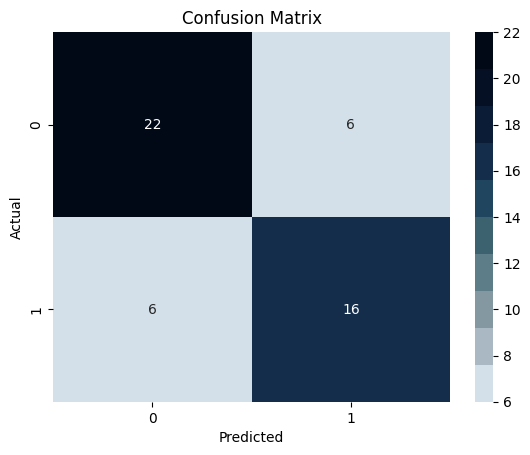

<Figure size 640x480 with 0 Axes>

In [ ]:
# Make predictions
predictions = combined_model.predict(test_imgs)
predictions

# Access predictions for the first task
ngt_present_predictions = predictions[0]
ngt_present_predictions
# Access predictions for the second task
ngt_normal_abnormal_predictions = predictions[1]

ngt_present_predictions
# Create two separate DataFrames
df1 = pd.DataFrame(ngt_present_predictions, columns=["NGT - Present"])
df2 = pd.DataFrame(ngt_normal_abnormal_predictions, columns=['NGT - Normal/Abnormal'])

# # Concatenate the DataFrames horizontally to create one with two columns
NGTpredictions = pd.concat([df1, df2], axis=1)
NGTpredictions

NGTpredictions['NGT - Present'] = np.where(NGTpredictions['NGT - Present'] > 0.5, 1, 0)
NGTpredictions['NGT - Normal/Abnormal'] = np.where(NGTpredictions['NGT - Normal/Abnormal'] > 0.5, 1, 0)
NGTpredictions

from sklearn.metrics import confusion_matrix

# Create the confusion matrix
confusion_matrix_present = confusion_matrix(test_labels, NGTpredictions['NGT - Present'])

plt.gca().patch.set_facecolor('none')



custom_palette = ['#D3E0EA', '#AAB8C4', '#8498A2', '#5D7D88', '#3C6270',
                  '#1F465E', '#132D4B', '#0A1C36', '#051024', '#020916']

# Create a heatmap plot of the confusion matrix
sns.heatmap(confusion_matrix_present, annot=True, cmap=custom_palette)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


plt.savefig('confusionmatrix_NGTexistence.png', bbox_inches='tight', transparent=True)


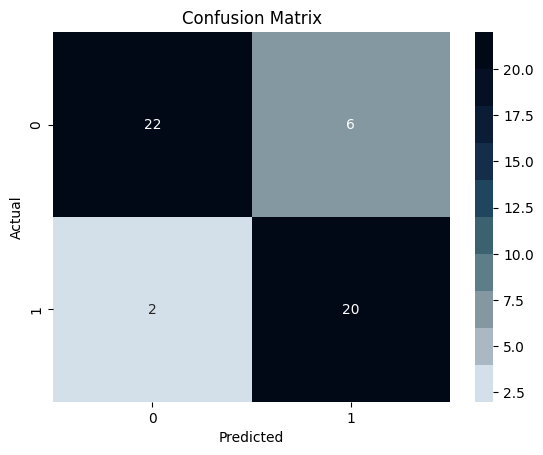

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix_normal = confusion_matrix(testNGT_labels, NGTpredictions['NGT - Normal/Abnormal'])

plt.gca().patch.set_facecolor('none')



custom_palette = ['#D3E0EA', '#AAB8C4', '#8498A2', '#5D7D88', '#3C6270',
                  '#1F465E', '#132D4B', '#0A1C36', '#051024', '#020916']

# Create a heatmap plot of the confusion matrix
sns.heatmap(confusion_matrix_normal, annot=True, cmap=custom_palette)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


# plt.savefig('confusionmatrix_CVCexistence.png', bbox_inches='tight', transparent=True)

In [ ]:
history.history

{'loss': [1.5461363792419434,
  0.8096561431884766,
  0.3624252378940582,
  0.12588241696357727,
  0.05198943614959717,
  0.06162864714860916,
  0.019237948581576347,
  0.017928985878825188,
  0.02415994368493557,
  0.009764919057488441,
  0.007427262607961893,
  0.007716720923781395,
  0.0050194538198411465,
  0.006688305176794529,
  0.014903539791703224,
  0.021240904927253723,
  0.0040471721440553665,
  0.007422173395752907,
  0.003778771497309208,
  0.007875504903495312,
  0.004931443836539984],
 'output_NGTpresent_loss': [0.7812063097953796,
  0.40417519211769104,
  0.19146518409252167,
  0.05916266515851021,
  0.028535082936286926,
  0.03126232326030731,
  0.009800111874938011,
  0.008465532213449478,
  0.009975463151931763,
  0.005508806090801954,
  0.0036987445782870054,
  0.004519784357398748,
  0.0022200404200702906,
  0.003765641711652279,
  0.007595089729875326,
  0.013587277382612228,
  0.0014799943892285228,
  0.0034188288263976574,
  0.0023902880493551493,
  0.0033364796

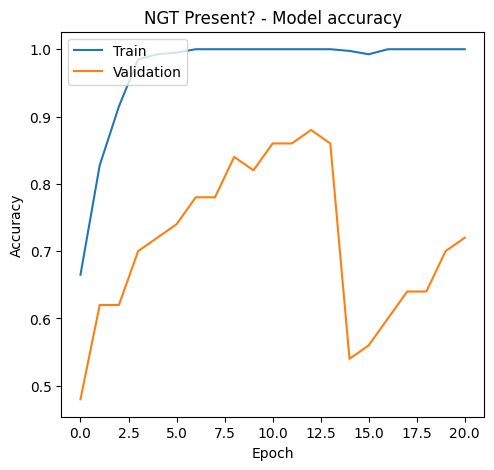

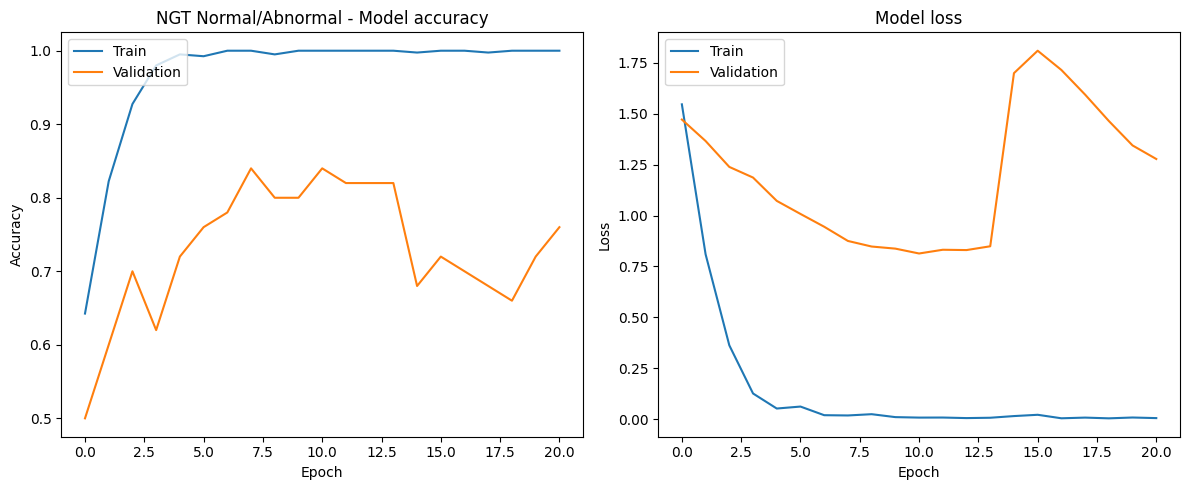

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['output_NGTpresent_accuracy'])
plt.plot(history.history['val_output_NGTpresent_accuracy'])
plt.title('NGT Present? - Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['output_NGTnormalAbnormal_accuracy'])
plt.plot(history.history['val_output_NGTnormalAbnormal_accuracy'])
plt.title('NGT Normal/Abnormal - Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()